In [1]:
from polygon import RESTClient
from datetime import datetime, timedelta
import pandas as pd
import json

# Initialize the client with your Polygon API key
api_key = "ftdnhkJhYOsOYJjqbGXi4Vxs7QuEOZYH"
client = RESTClient(api_key)

# # get exchanges
exchanges = pd.DataFrame(client.get_exchanges(asset_class='stocks',
                                              locale='us'))

# # exchanges MIC for use in list tickers
# print(exchanges.mic)

# # remove duplicates and remove None
exchangeList = list(set(exchanges.mic))
exchangeList.remove(None)


usTickers = []
for x in exchangeList:
    for t in client.list_tickers(market='stocks',
                                    exchange=x,
                                    limit=1000):
        # add to list
        usTickers.append(t.ticker)
            
# final ticker list
tickerList = list(set(usTickers))

In [2]:
from datetime import datetime

start = '2022-11-04'
end = '2024-11-02'
start_date = pd.to_datetime(start).date()
end_date = pd.to_datetime(end).date()
volumeDataFrames = []
for ticker in tickerList:
    try:
        dataRequest = client.get_aggs(ticker = ticker, 
                                    multiplier = (end_date-start_date).days +1,
                                    timespan = 'day',
                                    from_ = start,
                                    to = end)
    except:
        continue
    volumeData = pd.DataFrame(dataRequest)
    if len(volumeData) == 0:
        continue

    #create Date column
    volumeData['Ticker'] = ticker

    volumeData = volumeData[['Ticker', 'volume']]
    volumeDataFrames.append(volumeData)

volumeRankings = pd.concat(volumeDataFrames, ignore_index=True).sort_values(by='volume', ascending=False)
inScopeTickers = volumeRankings['Ticker'].to_list()[:100]

In [3]:
volumeRankings.to_csv('volumeRankings.csv')

In [10]:
dailyPriceDataFrames = []
for ticker in inScopeTickers:
    try:
        dataRequest = client.get_aggs(ticker = ticker, 
                                    multiplier = 1,
                                    timespan = 'day',
                                    from_ = start,
                                    to = end)
    except:
        continue
    dailyPriceData = pd.DataFrame(dataRequest)
    if len(dailyPriceData) == 0:
        continue

    #create Date column
    dailyPriceData['Date'] = dailyPriceData['timestamp'].apply(
                            lambda x: pd.to_datetime(x*1000000).date())
    dailyPriceData['Ticker'] = ticker
    dailyPriceData = dailyPriceData[['Ticker' ,'Date', 'close', 'volume']]
    dailyPriceData.rename(columns={'close': 'close_u'}, inplace=True)
    dailyPriceData['daily_return'] = dailyPriceData['close_u'].pct_change()
    dailyPriceData['Date'] = pd.to_datetime(dailyPriceData['Date'])

    splts = []
    for splt in client.list_splits(ticker = ticker):
        splts.append(splt)

    splitsDF = pd.DataFrame.from_records(
        [vars(split) for split in splts]
    )

    if len(splts) == 0:
        dailyPriceData['raw_close'] = dailyPriceData['close_u']
    else:
        splitsDF['split_multiple'] = splitsDF['split_to'] / splitsDF['split_from']

        dailyPriceData['raw_close'] = dailyPriceData['close_u']
        splitsDF['execution_date'] = pd.to_datetime(splitsDF['execution_date'])
        # Iterate over each split and adjust prices
        for _, split in splitsDF.iterrows():
            split_date = split['execution_date']
            split_multiple = split['split_multiple']
            
            # Apply the split adjustment to 'raw_close' for all dates on or before the split date
            dailyPriceData.loc[dailyPriceData['Date'] <= split_date, 'raw_close'] *= split_multiple


    dailyPriceData = dailyPriceData.sort_values(by='Date', ascending=True)

    dailyPriceDataFrames.append(dailyPriceData)

dailyUnderlying = pd.concat(dailyPriceDataFrames, ignore_index=True) 

In [12]:
dailyUnderlying.to_csv('dailyUnderlying.csv')

In [13]:
trading_days = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='B')
contracts1 = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='WOM-3FRI')
contracts2 = pd.date_range(start=datetime(2022,10,1), end=datetime(2026,1,1), freq='WOM-3FRI')+timedelta(days=1)
contracts = contracts1.append(contracts2)

In [14]:
pd.options.mode.chained_assignment= None
month_starts = pd.date_range(start="2021-10-01", end="2024-11-01", freq='QS')
optionContractsDataFrames = []
for ticker in inScopeTickers:
    tickerDF = dailyUnderlying[dailyUnderlying['Ticker'] == ticker]
    optionContracts = []
    tickers = []
    optionExpirations = set([])
    for m in month_starts:
        for c in client.list_options_contracts(underlying_ticker = ticker, limit = 1000, as_of=str(m)):
            if c.ticker not in tickers:
                if c.expiration_date in contracts and c.cfi in ['OCASPS','OPASPS']:
                    optionContracts.append(c)
                    optionExpirations.add(pd.to_datetime(c.expiration_date))
                    tickers.append(c.ticker)


    optionContractsDF = pd.DataFrame.from_records(
        [vars(contract) for contract in optionContracts]
    )
    if len(optionContractsDF) == 0:
        continue

    optionExpirations = pd.to_datetime(list(optionExpirations))
    for index, row in tickerDF.iterrows():
        price = row['raw_close']
        dtes = [30, 60, 90, 120]
        day_diff = [delta.days for delta in optionExpirations - pd.to_datetime(row['Date'])]

        indexes = []
        for dte in dtes:
            differences = [num-dte for num in day_diff]
            min_difference = min([abs(d) for d in differences])
            if -min_difference in differences and min_difference in differences:
                indexes.extend([i for i, diff in enumerate(differences) if diff == -min_difference])
            else:
                indexes.extend([i for i, diff in enumerate(differences) if abs(diff) == min_difference])

        # This will get the unique dates (at one index only)
        filtered_expiry_dates = set([str(optionExpirations[i].date()) for i in indexes])
        
        filteredExpiryOptionContracts = optionContractsDF[optionContractsDF['expiration_date'].isin(filtered_expiry_dates)]

        filteredExpiryOptionContracts['price_diff'] = (filteredExpiryOptionContracts['strike_price'] - price).abs()

        filteredOptions = (
            filteredExpiryOptionContracts.loc[filteredExpiryOptionContracts.groupby('expiration_date')['price_diff'].idxmin()]  # Get the index of the minimum distance
            .sort_values('strike_price', ascending=False)  # Sort by STRIKE_PRICE in descending order to resolve ties
            .drop_duplicates('expiration_date')  # Keep only the highest STRIKE_PRICE for ties
        )

        filteredOptions['Date'] = row['Date']  
        filteredOptions['Ticker'] = ticker  
        optionContractsDataFrames.append(filteredOptions)


optionContractsData = pd.concat(optionContractsDataFrames, ignore_index=True) 

In [15]:
optionContractsData.to_csv('optionContractsData.csv')

In [16]:
# WILL TAKE ABOUT 100 MINUTES TO RUN THIS FOR THE ENTIRE POPULATION
optionTradeInfoDataFrames = []

counter = 0

for contract_ticker in set(optionContractsData['ticker'].to_list()):
    dates = set(optionContractsData[optionContractsData['ticker'] == contract_ticker]['Date'].to_list())
    dates = [d.date() for d in dates]
    expiration_date = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'expiration_date'].iloc[0]
    strike_price = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'strike_price'].iloc[0]
    contract_type = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'contract_type'].iloc[0]
    underlying_ticker = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'underlying_ticker'].iloc[0]
    shares_per_contract = optionContractsData.loc[optionContractsData['ticker'] == contract_ticker, 'shares_per_contract'].iloc[0]
    try:
        dataRequest = client.get_aggs(ticker = contract_ticker, 
                                multiplier = 1,
                                timespan = 'day',
                                from_ = str(min(dates)),
                                to = str(max(dates)))      
    except:
        dataRequest = client.get_aggs(ticker = contract_ticker, 
                                multiplier = 1,
                                timespan = 'day',
                                from_ = '2022-11-04',
                                to = '2024-11-01')

    optionData = pd.DataFrame(dataRequest)    
    if len(optionData) ==0:
        continue

    optionData['Date'] = optionData['timestamp'].apply(
                            lambda x: pd.to_datetime(x*1000000))
    optionData = optionData.set_index('Date')
    optionData['Date'] = optionData['timestamp'].apply(
                          lambda x: pd.to_datetime(x*1000000).date())

    optionData = optionData[optionData['Date'].isin(dates)]
    
    optionData['ticker'] = contract_ticker
    optionData['expiration_date'] = expiration_date
    optionData['strike_price'] = strike_price
    optionData['contract_type'] = contract_type
    optionData['underlying_ticker'] = underlying_ticker
    optionData['shares_per_contract'] = shares_per_contract
    optionTradeInfoDataFrames.append(optionData)
    # print(counter)
    counter += 1 
    if counter % 500 == 0:
        print(counter)
    # if counter == 100:
    #     break
    # pass


optionTradeInfoData = pd.concat(optionTradeInfoDataFrames, ignore_index=True) 

optionTradeInfoData = optionTradeInfoData[['Date', 'underlying_ticker', 'ticker', 'close', 'expiration_date', 'strike_price', 'contract_type', 'shares_per_contract']]
optionTradeInfoData.rename(columns={'close': 'close_o'}, inplace=True)

optionTradeInfoData['Date'] = pd.to_datetime(optionTradeInfoData['Date'])
optionTradeInfoData['expiration_date'] = pd.to_datetime(optionTradeInfoData['expiration_date'])

# Calculate the day difference between expiration_date and Date
optionTradeInfoData['day_difference'] = (optionTradeInfoData['expiration_date'] - optionTradeInfoData['Date']).dt.days

# Define the thresholds for the expiration months
thresholds = {30: 1, 60: 2, 90: 3, 120: 4}

# Function to find the closest month number based on day difference
def assign_expiration_month(day_diff):
    closest_days = min(thresholds.keys(), key=lambda x: abs(x - day_diff))
    return thresholds[closest_days]

# Apply the function to assign the expiration month
optionTradeInfoData['expiration_month'] = optionTradeInfoData['day_difference'].apply(assign_expiration_month)

# Drop the helper column if not needed
optionTradeInfoData = optionTradeInfoData.drop(columns='day_difference')
optionTradeInfoData = optionTradeInfoData.sort_values(['underlying_ticker','Date', 'expiration_date'])


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000


In [17]:
optionTradeInfoData.to_csv('optionTradeInfoData.csv')

In [18]:
dailyUnderlying['Date'] = pd.to_datetime(dailyUnderlying['Date'])
optionTradeInfoData['Date'] = pd.to_datetime(optionTradeInfoData['Date'])

underlyingOptionJoinDF = pd.merge(
    dailyUnderlying,
    optionTradeInfoData,
    how='left',  # Inner join
    left_on=['Date', 'Ticker'],  # Columns in dailyUnderlying to join on
    right_on=['Date', 'underlying_ticker']  # Columns in optionTradeInfoData to join on
)

In [56]:
import pandas as pd
import yfinance as yf
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define start and end dates for the range
start_date = '2022-11-04'
end_date = '2024-11-01'

# Generate a DataFrame with a daily date range
dates_df = pd.DataFrame({"Date": pd.date_range(start=start_date, end=end_date, freq='D')})
dates_df['Date'] = pd.to_datetime(dates_df['Date'])
# Fetch the 3-month Treasury yield data from Yahoo Finance using "^IRX"
try:
    t_bill_data = yf.download("^IRX", start=start_date, end=end_date, interval="1d", )['Close']

    # Rename column to '3 Month Risk-Free Rate' and adjust to a percentage (assuming basis points)

    t_bill_data = t_bill_data.reset_index()
    t_bill_data['Date'] = pd.to_datetime(t_bill_data['Date']).dt.tz_localize(None)
    t_bill_data.rename(columns={'^IRX': 'Risk Free Rate'}, inplace=True)
    rates_df = dates_df.merge(t_bill_data, left_on='Date', right_on='Date', how='left')
    rates_df['Risk Free Rate'] = rates_df['Risk Free Rate'].fillna(method='ffill')
except Exception as e:
    print("Error fetching data from yfinance:", e)


[*********************100%***********************]  1 of 1 completed


In [67]:
underlyingOptionJoinDF = underlyingOptionJoinDF.merge(rates_df, left_on='Date', right_on='Date', how='left')

In [68]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq
from scipy.stats import norm
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# NOTE AOBUT AMERICAN OPTIONS

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Black-Scholes model for option pricing
def black_scholes_price(S, K, T, r, sigma, option_type):
    """Calculate the Black-Scholes price for a call or put option."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be either 'call' or 'put'")
        
    return price

# Implied volatility calculation
def implied_volatility(S, K, T, r, market_price, option_type):
    """Calculate the implied volatility using a numerical solver."""
    try:
        # Define a function whose root (solution) will give us the implied volatility
        implied_vol_func = lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - market_price
        # Use brentq solver to find the root within a reasonable range for volatility
        return brentq(implied_vol_func, 1e-5, 5)  # Limits set to ensure solution stability
    except ValueError:
        return np.nan  # Return NaN if no solution is found

# Main function to add implied volatility to the DataFrame
def add_implied_volatility(df):
    """Add an 'implied_volatility' column to the DataFrame."""
    iv_values = []
    
    for _, row in df.iterrows():
        if str(row['close_o']) == 'nan':
            iv_values.append(np.nan)
            continue
        S = row['raw_close']
        K = row['strike_price']
        T = (pd.to_datetime(row['expiration_date']).date() - row['Date'].date()).days / 365  # Time to expiration in years
        r = row['Risk Free Rate']  / 100
        market_price = row['close_o'] 
        option_type = row['contract_type']
        
        # Calculate implied volatility
        iv = implied_volatility(S, K, T, r, market_price, option_type)
        iv_values.append(iv)
    
    # Add new column to the DataFrame
    df['implied_volatility'] = iv_values
    return df


In [69]:

underlyingOptionJoinDF = add_implied_volatility(underlyingOptionJoinDF)

In [61]:
def calculate_realized_volatility(row, df):
    start_date = row['Date'] + pd.Timedelta(days=1)  # Day after the option pricing date
    end_date = row['expiration_date']
    underlying_ticker = row['underlying_ticker']
    if str(end_date) == 'nan':
        return
    if end_date not in df['Date'].values:
        return 
    # Filter daily returns for the specified date range
    returns_in_range = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) & (df['underlying_ticker'] == underlying_ticker)]['daily_return']

    # Calculate realized volatility if there are returns in the range
    if not returns_in_range.empty:
        realized_vol = np.std(returns_in_range, ddof=1) * np.sqrt(252)  # Annualizing based on trading days
        return realized_vol
    else:
        return np.nan

In [22]:
underlyingOptionJoinDF['realized_volatility'] = underlyingOptionJoinDF.apply(calculate_realized_volatility, axis=1,  args=(underlyingOptionJoinDF,))

In [70]:
underlyingOptionJoinDF.to_csv('underlyingOptionJoinDF.csv')

# ANALYSIS

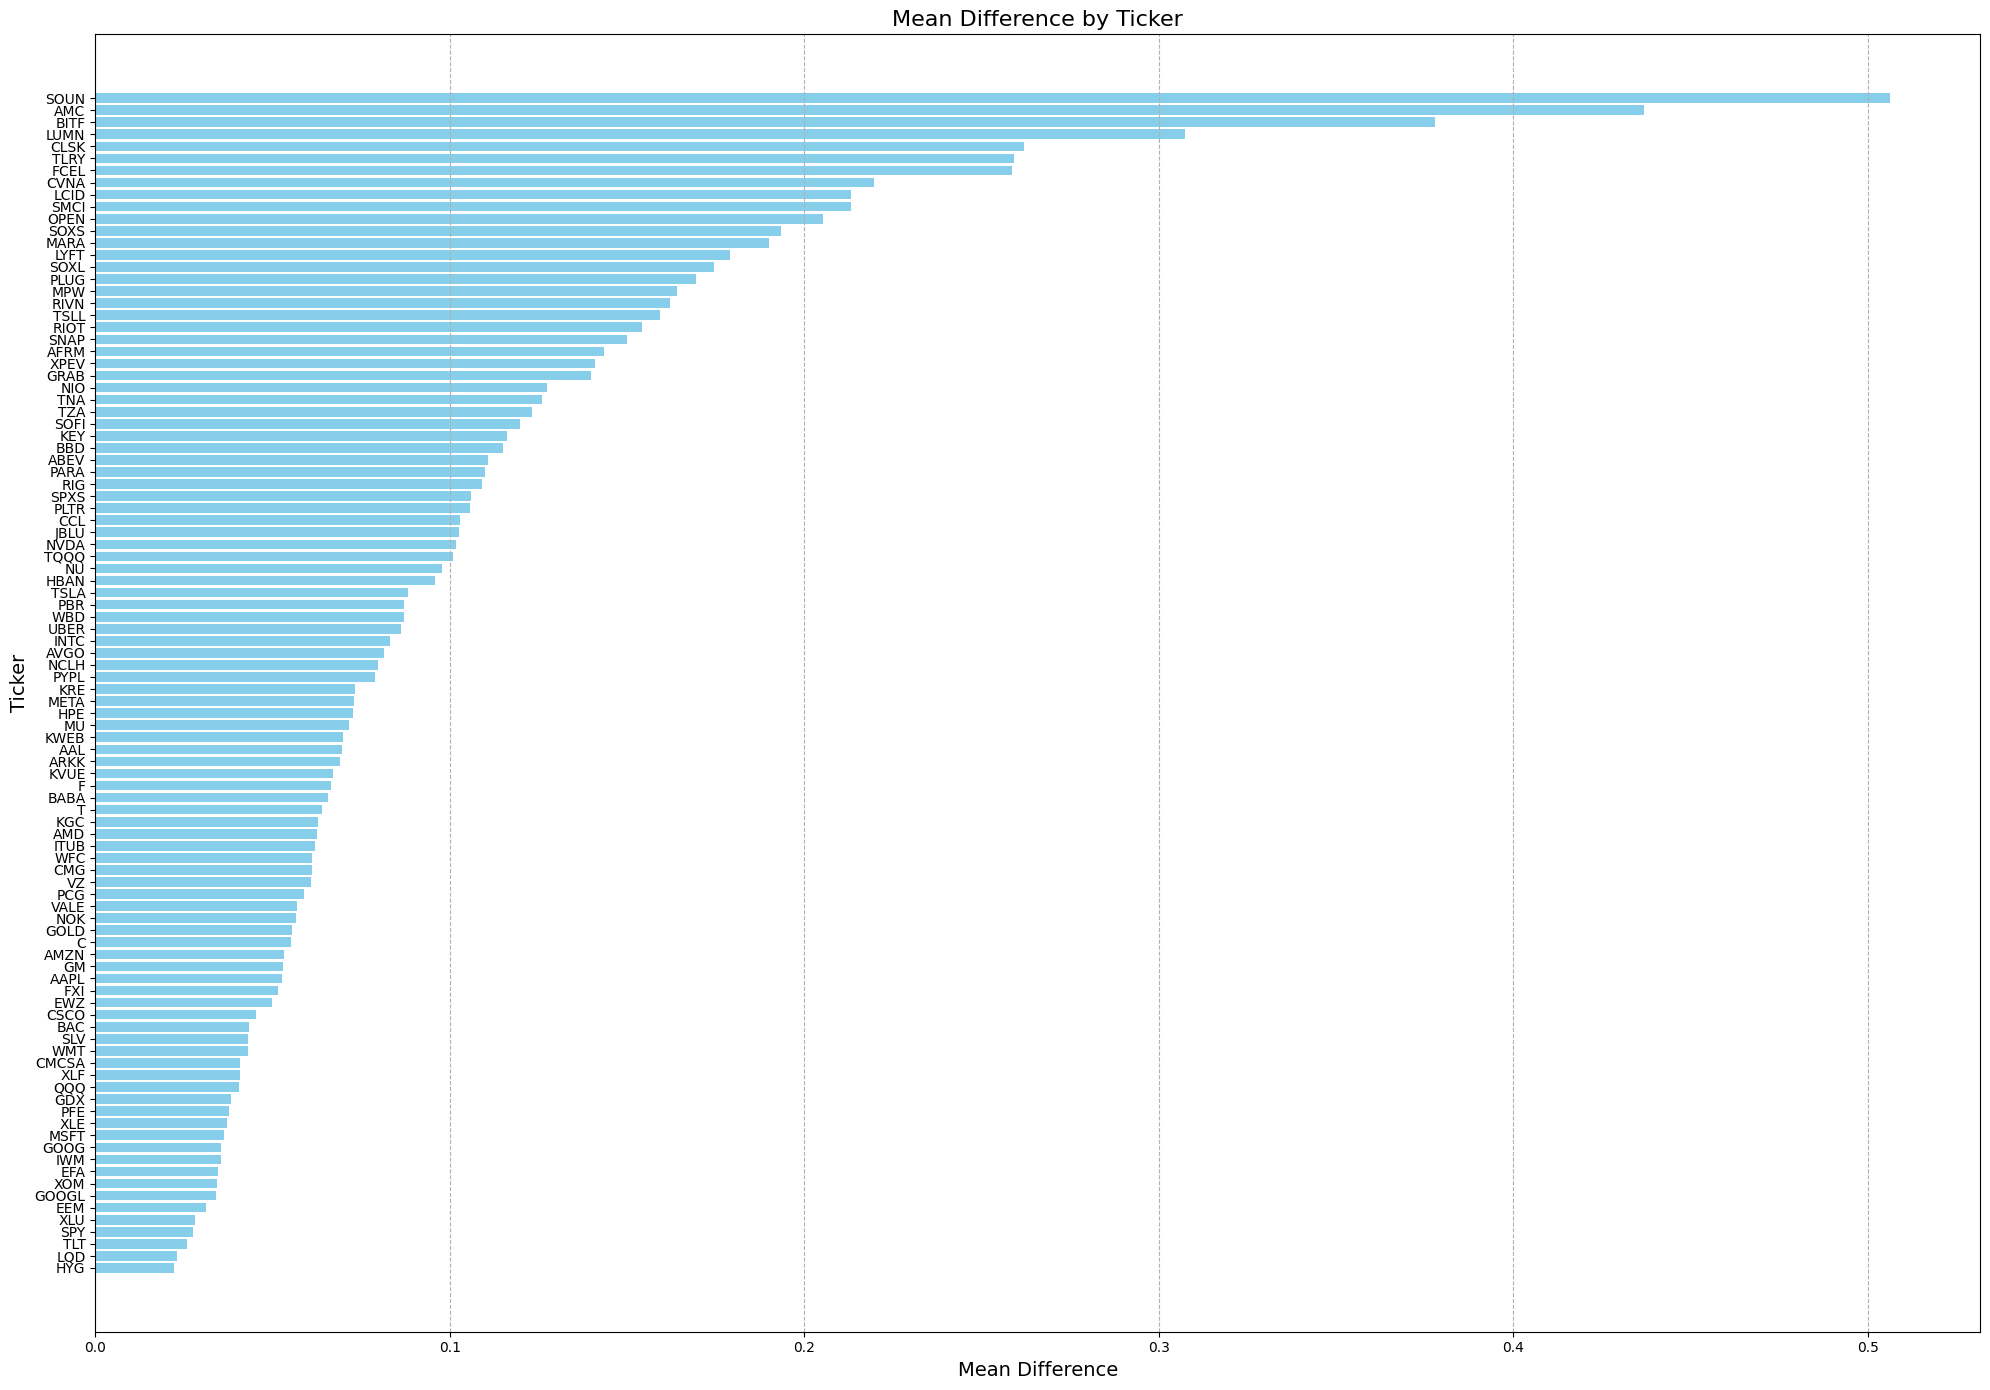

In [89]:
import matplotlib.pyplot as plt

analysis_df = underlyingOptionJoinDF.dropna(subset=['implied_volatility', 'realized_volatility'])
analysis_df['vol_abs_diff'] = abs(analysis_df['implied_volatility'] - analysis_df['realized_volatility'])
analysis_df['vol_diff'] = analysis_df['implied_volatility'] - analysis_df['realized_volatility']
mean_difference_df = analysis_df.groupby('Ticker', as_index=False).agg(
    mean_abs_difference=('vol_abs_diff', 'mean'))
mean_difference_df = mean_difference_df.sort_values(by='mean_abs_difference', ascending=True)
mean_difference_df

plt.figure(figsize=(20, 14))
plt.barh(mean_difference_df['Ticker'], mean_difference_df['mean_abs_difference'], color='skyblue')

# Set the title and labels
plt.title('Mean Difference by Ticker', fontsize=16)
plt.xlabel('Mean Difference', fontsize=14)
plt.ylabel('Ticker', fontsize=14)

# Display the grid
plt.grid(axis='x', linestyle='--')

# Show the plot
plt.tight_layout()  # Adjust layout
plt.show()

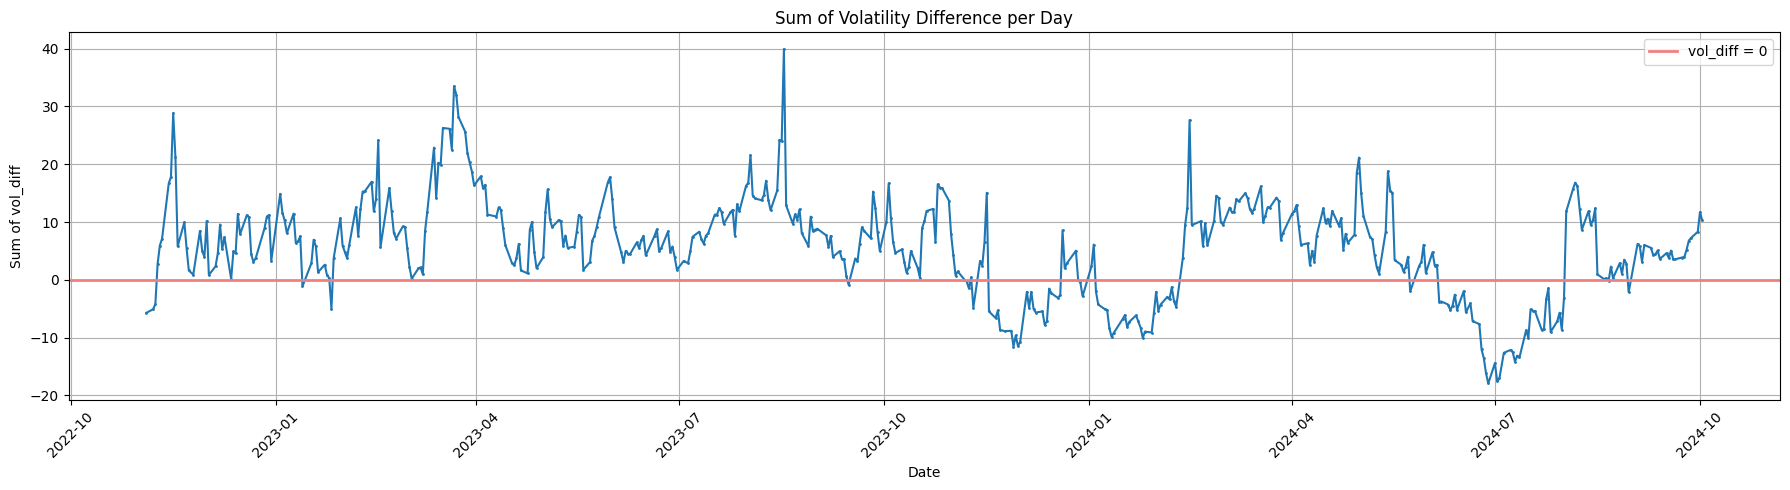

In [96]:
daily_vol_diff_sum = analysis_df.groupby('Date', as_index=False)['vol_diff'].sum()

# Plotting
plt.figure(figsize=(18, 5))
plt.plot(daily_vol_diff_sum['Date'], daily_vol_diff_sum['vol_diff'], marker='o', linestyle='-', markersize=1)
plt.axhline(y=0, color='lightcoral', linewidth=2, linestyle='-', label='vol_diff = 0')  # Add the horizontal line

plt.title('Sum of Volatility Difference per Day')
plt.xlabel('Date')
plt.ylabel('Sum of vol_diff')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.legend()  # Add a legend to show what the line represents
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()